In [2]:
%matplotlib inline

# scientific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
from kabuki.analyze import check_geweke
from kabuki.analyze import gelman_rubin

# miscellaneous
from IPython.display import clear_output

**Author: Janet Li**\
**Date: 12/2/2024**

# Research Question

Do healthy individuals, individuals with remitted depression, and individuals with current depression and suicidal ideation differ in the speed of evidence accumulation (i.e., drift rate) in a task that assesses cognitive control (i.e., the flanker task)?

# Variables

- `rt`: response time (in seconds)
- `response`: response made (left or right)
- `trial_type`: whether the trial consisted of congruent or incongruent targets
- `group`: whether the individual was healthy (HC), had remitted depression (rMDD), or had current depression and suicidal ideation (SI)
- $\alpha$: boundary separation parameter in a drift diffusion model (DDM), which measures how much evidence needs to accumulated for a response to be executed.
- v: drift rate parameter in a DDM, which measures the speed of evidence accumulation.
- t: non-decision time parameter in a DDM, which measures the time taken to perform non-decision behaviors (e.g., perception, movement initiation and execution).
- z: bias parameter in a DDM, which measures the prepotent bias towards a certain stimulus.

## Data Import

In [25]:
data = hddm.load_csv("../all_cleaned/flanker_all.csv")
# exclude rows according to the exclusion flags
data_clean = data.loc[(data.exclude_trial == 0) & (data.exclude_part == 0), :]
# rename columns according to the HDDM model convention
data_clean = data_clean.rename(columns={"resp_rt": "rt", "resp_value": "response",
                                        "trial_congruent_fac": "trial_type",
                                        "subject_id": "subj_idx"})

In [26]:
data_clean.head()

,subj_idx,trial_type,resp_corr,rt,response,mean_rt,sd_rt,exclude_thresh,exclude_trial,exclude_part,school,group
0,1903,congruent,1,0.841311,left,0.945541,0.158969,2.4,0,0,UIC,rMDD
1,1903,incongruent,1,1.105856,right,1.020937,0.151395,2.4,0,0,UIC,rMDD
2,1903,incongruent,1,1.151826,left,1.020937,0.151395,2.4,0,0,UIC,rMDD
3,1903,congruent,1,0.710728,right,0.945541,0.158969,2.4,0,0,UIC,rMDD
4,1903,incongruent,1,0.956795,left,1.020937,0.151395,2.4,0,0,UIC,rMDD


## Variable Summary

The following table shows the summary statistics of response times by group and trial type.

In [34]:
data_clean[["rt", "group", "trial_type"]].groupby(["group", "trial_type"]).describe()

rt                                                     
                    count      mean       std       min       25%       50%   
group trial_type                                                              
HC    congruent    1216.0  0.569351  0.117414  0.349459  0.486819  0.548058  \
      incongruent  1213.0  0.647026  0.140774  0.323711  0.559814  0.621350   
SI    congruent     688.0  0.609570  0.170033  0.000000  0.495791  0.576894   
      incongruent   690.0  0.701379  0.184837  0.325547  0.581031  0.659431   
rMDD  congruent    1213.0  0.608990  0.209955  0.330845  0.488824  0.565600   
      incongruent  1211.0  0.708031  0.258034  0.326785  0.570508  0.647860   

                                       
                        75%       max  
group trial_type                       
HC    congruent    0.628956  1.297988  
      incongruent  0.713315  1.529910  
SI    congruent    0.671899  1.722197  
      incongruent  0.789454  1.535628  
rMDD  congruent    0.654650  2.362939  
      incongruent  0.753425  3.149707

In [35]:
data_clean[["response", "group", "trial_type"]].groupby(["group", "trial_type"]).describe()

response                   
                     count unique    top freq
group trial_type                             
HC    congruent       1216      2   left  610
      incongruent     1213      2  right  609
SI    congruent        688      3   left  346
      incongruent      690      2   left  347
rMDD  congruent       1213      2  right  609
      incongruent     1211      2   left  619

# Model

Let $Y$ = [`rt`, `response`]

$Y_{ij} \sim F(a_i, z_i, v_i, t_i, sv, st, sz)$

Where $F$ represents the DDM likelihood function as formulated by Daniel et al. (2009).

$\mu_\alpha \sim \Gamma(1.5, 0.75)$\
$\mu_v \sim N(2, 3)$\
$\mu_z \sim N(0.5, 0.5)$\
$\mu_t \sim \Gamma(0.4, 0.2)$\
\
$\sigma_\alpha \sim HN(0.1)$\
$\sigma_v \sim HN(2)$\
$\sigma_z \sim HN(0.05)$\
$\sigma_t \sim HN(1)$\
\
$\alpha_j \sim \Gamma(\mu_\alpha, \sigma^2_\alpha)$\
$z_j \sim invlogit(N(\mu_z, \sigma^2_z))$\
$v_j \sim N(\mu_v, \sigma^2_t)$\
$t_j \sim N(\mu_t, \sigma^2_t)$\
\
$sv \sim HN(2)$\
$st \sim HN(0.3)$\
$sz \sim B(1, 3)$\
\
Where $N$ represents a normal distribution parameterized by mean $\mu$ and standard deviation $\sigma$, $HN$ represents a half-normal distribution bounded at 0 and parameterized by standard deviation $\sigma$, $\Gamma$ represents a Gamma distribution parameterized by shape $\alpha$ and rate $\beta$, and $B$ represents a Beta distribution parameterized by $\alpha$ and $\beta$.

## Analysis

Here I only present a model that estimates all 4 parameters and regresses `v` on an interaction between `group` and `trial_type`. \
I used 4 chains, each with 10000 iterations (first 5000 as warm-ups). Only every 5th sample was saved, resulting in 1000 samples per chain.

In [ ]:
model_name = "m_reg_group*cond"
m_reg = hddm.models.HDDMRegressor(df, 'v ~ C(group):C(trial_type)', include=['a', 'v', 'z', 't'])
m_reg.sample(10000, burn=5000, chains=4, return_infdata=True, save_name="../models/" + model_name,
                             progress_bar=True, thin=5)

# Results

In [9]:
m_reg = hddm.load("../models/m_reg_group*cond.hddm")

## Convergence Diagnostics

In [21]:
params = ['a', 't', 'z', 
          'v_Intercept', 
          'v_C(trial_type)[T.incongruent]',
          'v_C(group)[T.SI]:C(trial_type)[congruent]',
          'v_C(group)[T.rMDD]:C(trial_type)[congruent]',
          'v_C(group)[T.SI]:C(trial_type)[incongruent]',
          'v_C(group)[T.rMDD]:C(trial_type)[incongruent]']

Plotting a
Plotting t
Plotting z
Plotting v_Intercept
Plotting v_C(trial_type)[T.incongruent]
Plotting v_C(group)[T.SI]:C(trial_type)[congruent]
Plotting v_C(group)[T.rMDD]:C(trial_type)[congruent]
Plotting v_C(group)[T.SI]:C(trial_type)[incongruent]
Plotting v_C(group)[T.rMDD]:C(trial_type)[incongruent]


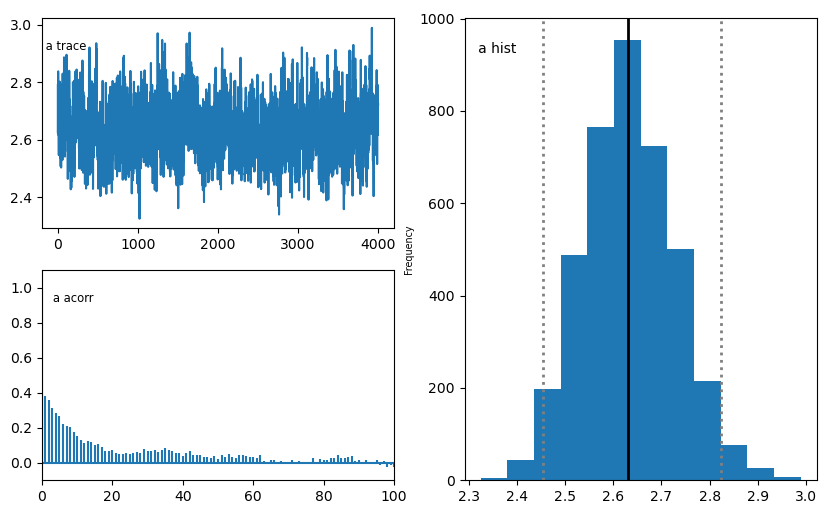

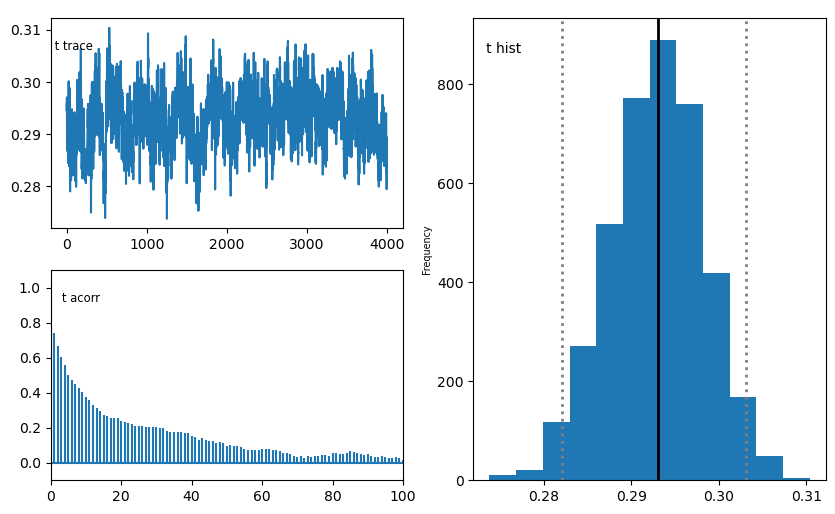

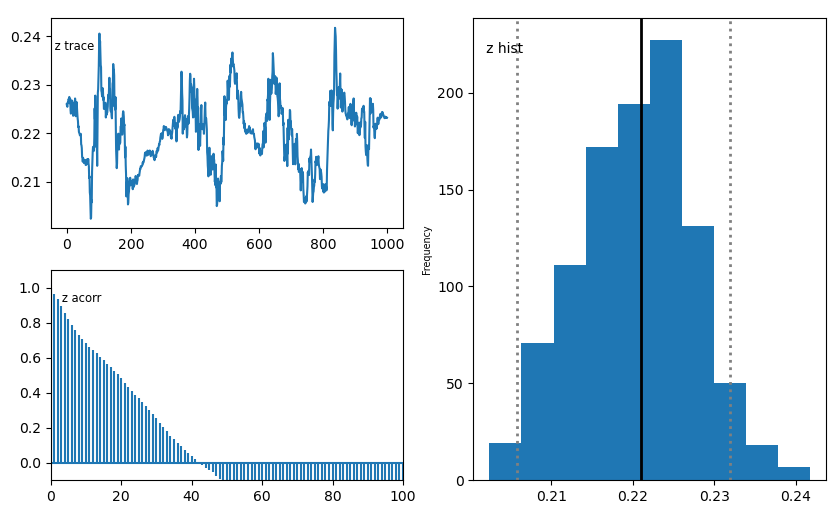

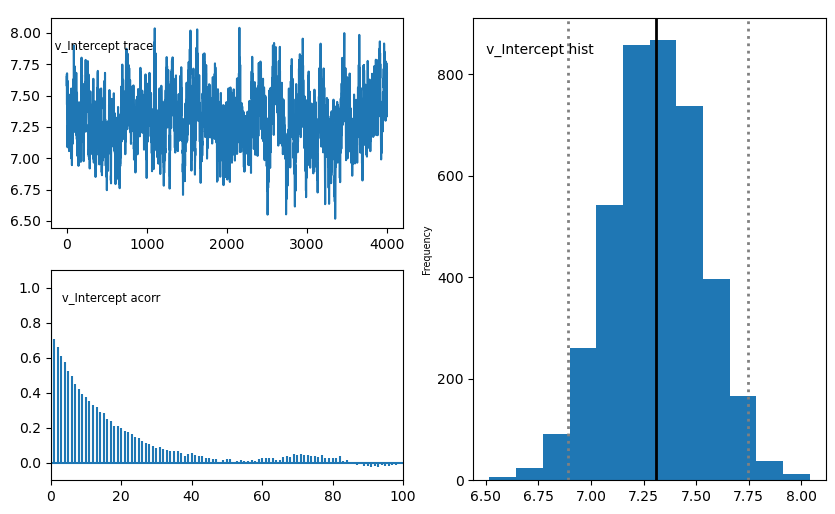

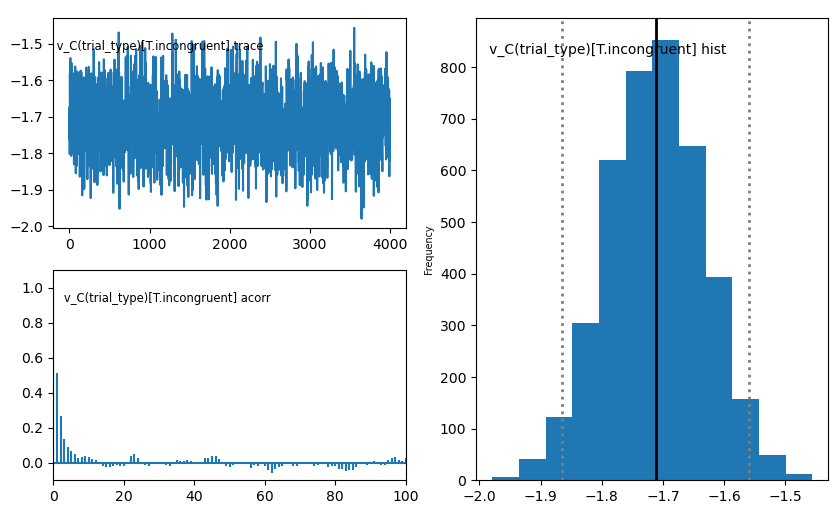

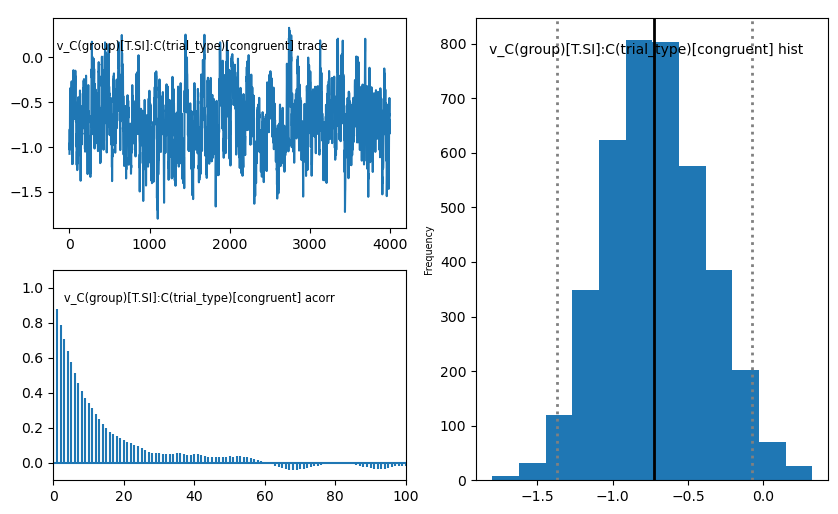

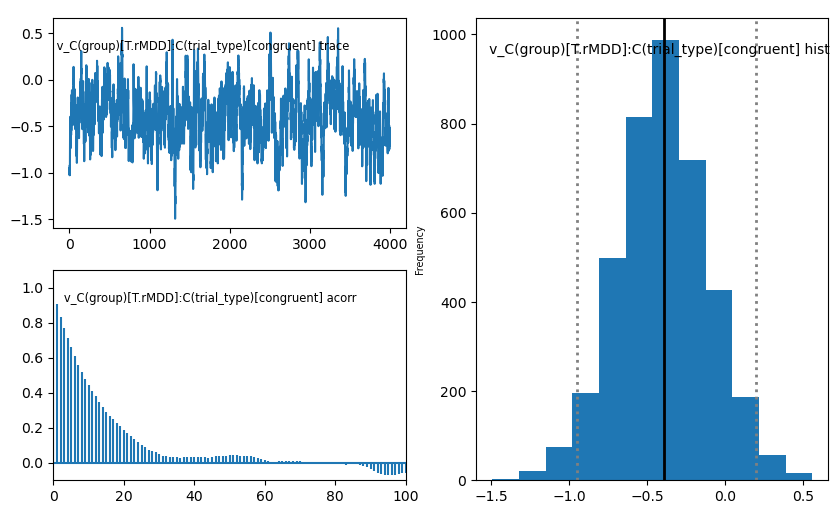

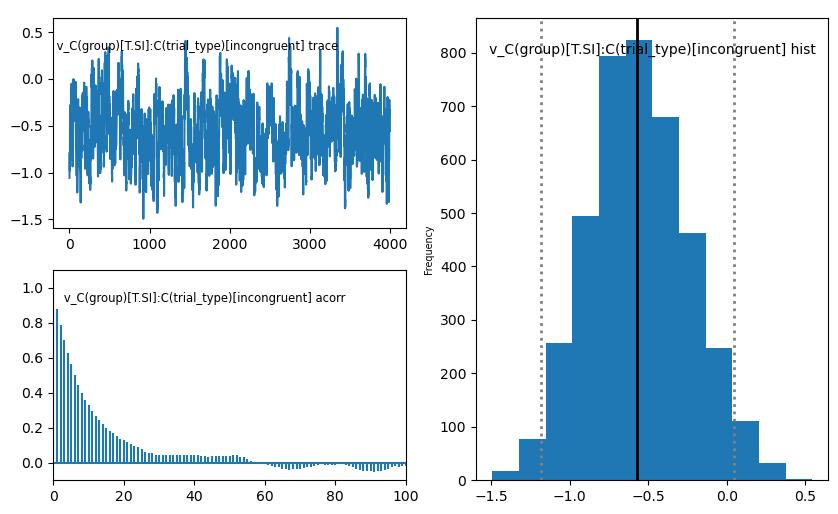

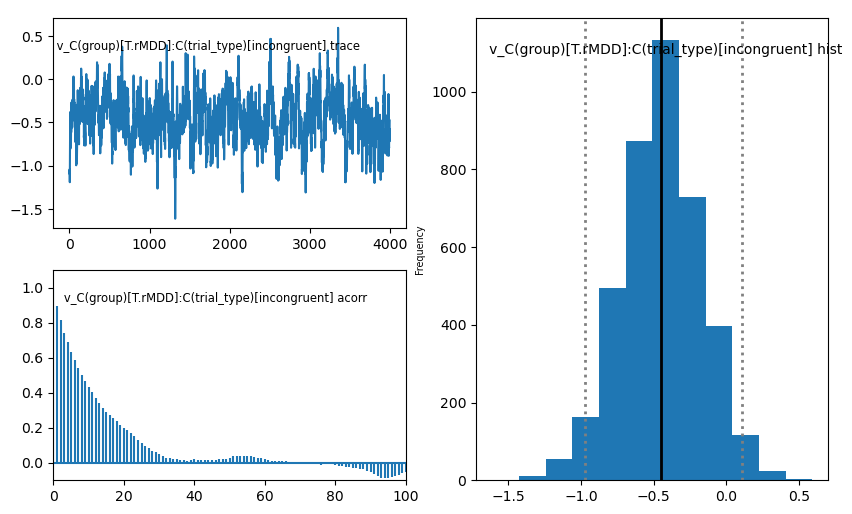

In [22]:
# Trace plots
m_reg.plot_posteriors(params)

## Posterior Distributions

In [23]:
stats = m_reg.gen_stats()
stats[stats.index.isin(params)]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.634257,0.095483,2.457069,2.568394,2.631004,2.698773,2.829102,0.004049
t,0.2929,0.005365,0.282113,0.289346,0.29309,0.296626,0.303088,0.000332
z,0.22038,0.006889,0.207212,0.215288,0.220972,0.224888,0.233855,0.000649
v_Intercept,7.309539,0.218687,6.878841,7.163118,7.308666,7.45948,7.739039,0.013434
v_C(trial_type)[T.incongruent],-1.712452,0.07877,-1.867891,-1.766828,-1.711131,-1.659821,-1.5625,0.002282
v_C(group)[T.SI]:C(trial_type)[congruent],-0.712297,0.33551,-1.333878,-0.947996,-0.726245,-0.48059,-0.030301,0.020345
v_C(group)[T.rMDD]:C(trial_type)[congruent],-0.397916,0.288671,-0.97463,-0.587161,-0.394161,-0.211399,0.181765,0.018439
v_C(group)[T.SI]:C(trial_type)[incongruent],-0.557444,0.317975,-1.146528,-0.779555,-0.573029,-0.337942,0.091049,0.019297
v_C(group)[T.rMDD]:C(trial_type)[incongruent],-0.447095,0.274718,-1.00644,-0.624277,-0.450853,-0.264316,0.07829,0.017429


In [78]:
v_hc_con = m_reg.nodes_db.node['v_Intercept'].trace()
v_hc_con_mean = v_hc_con.mean()
v_hc_con_sd = v_hc_con.std()
v_hc_con_025 = np.percentile(v_hc_con, .025)
v_hc_con_975 = np.percentile(v_hc_con, .975)

v_hc_incon = m_reg.nodes_db.node['v_Intercept'].trace() +\
m_reg.nodes_db.node['v_C(trial_type)[T.incongruent]'].trace()
v_hc_incon_mean = v_hc_incon.mean()
v_hc_incon_sd = v_hc_incon.std()
v_hc_incon_025 = np.percentile(v_hc_incon, .025)
v_hc_incon_975 = np.percentile(v_hc_incon, .975)

v_rmdd_con = m_reg.nodes_db.node['v_Intercept'].trace() +\
                   m_reg.nodes_db.node['v_C(group)[T.rMDD]:C(trial_type)[congruent]'].trace()
v_rmdd_con_mean = v_rmdd_con.mean()
v_rmdd_con_sd = v_rmdd_con.std()
v_rmdd_con_025 = np.percentile(v_rmdd_con, .025)
v_rmdd_con_975 = np.percentile(v_rmdd_con, .975)

v_rmdd_incon = m_reg.nodes_db.node['v_Intercept'].trace() +\
                     m_reg.nodes_db.node['v_C(group)[T.rMDD]:C(trial_type)[congruent]'].trace() +\
                     m_reg.nodes_db.node['v_C(group)[T.rMDD]:C(trial_type)[incongruent]'].trace()
v_rmdd_incon_mean = v_rmdd_incon.mean()
v_rmdd_incon_sd = v_rmdd_incon.std()
v_rmdd_incon_025 = np.percentile(v_rmdd_incon, .025)
v_rmdd_incon_975 = np.percentile(v_rmdd_incon, .975)

v_si_con = m_reg.nodes_db.node['v_Intercept'].trace() +\
                 m_reg.nodes_db.node['v_C(group)[T.SI]:C(trial_type)[congruent]'].trace()
v_si_con_mean = v_si_con.mean()
v_si_con_sd = v_si_con.std()
v_si_con_025 = np.percentile(v_si_con, .025)
v_si_con_975 = np.percentile(v_si_con, .975)

v_si_incon = m_reg.nodes_db.node['v_Intercept'].trace() +\
                   m_reg.nodes_db.node['v_C(group)[T.SI]:C(trial_type)[congruent]'].trace() +\
                   m_reg.nodes_db.node['v_C(group)[T.SI]:C(trial_type)[incongruent]'].trace()
v_si_incon_mean = v_si_incon.mean()
v_si_incon_sd = v_si_incon.std()
v_si_incon_025 = np.percentile(v_si_incon, .025)
v_si_incon_975 = np.percentile(v_si_incon, .975)

In [79]:
pd.DataFrame({'mean': [v_hc_con_mean, v_hc_incon_mean, 
                      v_rmdd_con_mean, v_rmdd_incon_mean,
                      v_si_con_mean, v_si_incon_mean],
             'sd': [v_hc_con_sd, v_hc_incon_sd, 
                      v_rmdd_con_sd, v_rmdd_incon_sd,
                      v_si_con_sd, v_si_incon_sd],
             '2.5q': [v_hc_con_025, v_hc_incon_025, 
                      v_rmdd_con_025, v_rmdd_incon_025,
                      v_si_con_025, v_si_incon_025],
             '97.5q': [v_hc_con_975, v_hc_incon_975, 
                      v_rmdd_con_975, v_rmdd_incon_975,
                      v_si_con_975, v_si_incon_975]},
            index=['HC congruent', 'HC incongruent',
                  'rMDD congruent', 'rMDD incongruent',
                  'SI congruent', 'SI incongrent'])

,mean,sd,2.5q,97.5q
HC congruent,7.309539,0.218687,6.549412,6.799149
HC incongruent,5.597087,0.211446,4.845594,5.113322
rMDD congruent,6.911623,0.213450,6.142141,6.406015
rMDD incongruent,6.464528,0.438856,4.843601,5.366224
SI congruent,6.597242,0.269167,5.831092,5.990754
SI incongrent,6.039798,0.542169,4.484290,4.849278


For HCs, their average drift rate was 7.31 on congruent trials, and switching to incongruent trials significantly slowed down their drift rates (v_C(trial_type)[T.incongruent] = -1.71, 95%CI = [-1.87, -1.56]). Drift rate of individuals with rMDD did not differ significantly from that of HCs during congruent trials (v_C(group)[T.rMDD]:C(trial_type)[congruent] = -0.40, 95%CI = [-0.97, 0.18]). Drift rate of individuals with current SI was significantly lower than that of HCs during congruent trials (v_C(group)[T.SI]:C(trial_type)[congruent] = -0.71, 95%CI = [-1.33, -0.03]). The average drift rate of individuals with rMDD during incongruent trials was 6.46, and that of individuals with current SI during incongruent trials was 6.04.